# 1. Preparación de entorno. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from pmdarima import auto_arima
%pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
import ruptures as rpt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
import joblib

Note: you may need to restart the kernel to use updated packages.


# 2. Carga de datos. 

In [2]:
# Load the lake hydrology data
df_ws = pd.read_csv("../data/processed/water_spring/water_spring_hydrology_data_clean.csv")
df_ws.head()

,Date,Rainfall_Value,Temperature_Value,Flow_Rate_Value,Depth_to_Groundwater_Value
0,2000-01-01,0.0,0.0,0.0,0.0
1,2001-01-01,0.0,0.0,0.0,0.0
2,2002-01-01,0.0,0.0,0.0,0.0
3,2003-01-01,0.0,0.0,0.0,0.0
4,2004-01-01,0.0,0.0,0.0,0.0


# 3. Definir Features (X) y Variable Target (Y). 

Para definir las variables features y la variable target, se considerarán los datos que nos son útiles para visualizar el nivel de agua según la fecha de cada cuerpo de agua, en este caso __"Value"__ es la variable target, mientras que el resto de las variables se considerarán variables feature.

# 4. Dividir data en train y test. 

In [3]:
df_ws["Date"] = pd.to_datetime(df_ws["Date"])

In [4]:
df_ws.set_index("Date", inplace=True)

In [5]:
df_ws.sort_index(inplace=True)

In [6]:
df_monthly = df_ws.resample('M').mean() 

/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_67962/2707236978.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_ws.resample('M').mean()


In [7]:
df_monthly.head()

,Rainfall_Value,Temperature_Value,Flow_Rate_Value,Depth_to_Groundwater_Value
Date,,,,
2000-01-31,0.0,0.645161,0.0,0.0
2000-02-29,0.0,1.200431,0.0,0.0
2000-03-31,0.0,1.646371,0.0,0.0
2000-04-30,0.0,2.484583,0.0,0.0
2000-05-31,0.0,3.839919,0.0,0.0


In [8]:
df = df_monthly

In [9]:
split_date = '2019-01-01' # Ejemplo de tu fecha de división
train_df = df[:split_date]
test_df = df.loc[(df.index > split_date)]

In [10]:
# Dividir los datos en entrenamiento y prueba
n_obs = 50 # Número de observaciones para predecir
train_df = train_df[:-n_obs]
test_df = test_df[-n_obs:]

print(f"Tamaño del conjunto de entrenamiento: {len(train_df)}")
print(f"Tamaño del conjunto de prueba: {len(test_df)}")

Tamaño del conjunto de entrenamiento: 178
Tamaño del conjunto de prueba: 18


# 5. Generar Modelo. 

/Users/bereniceramos/miniconda3/envs/new_pmdarima_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


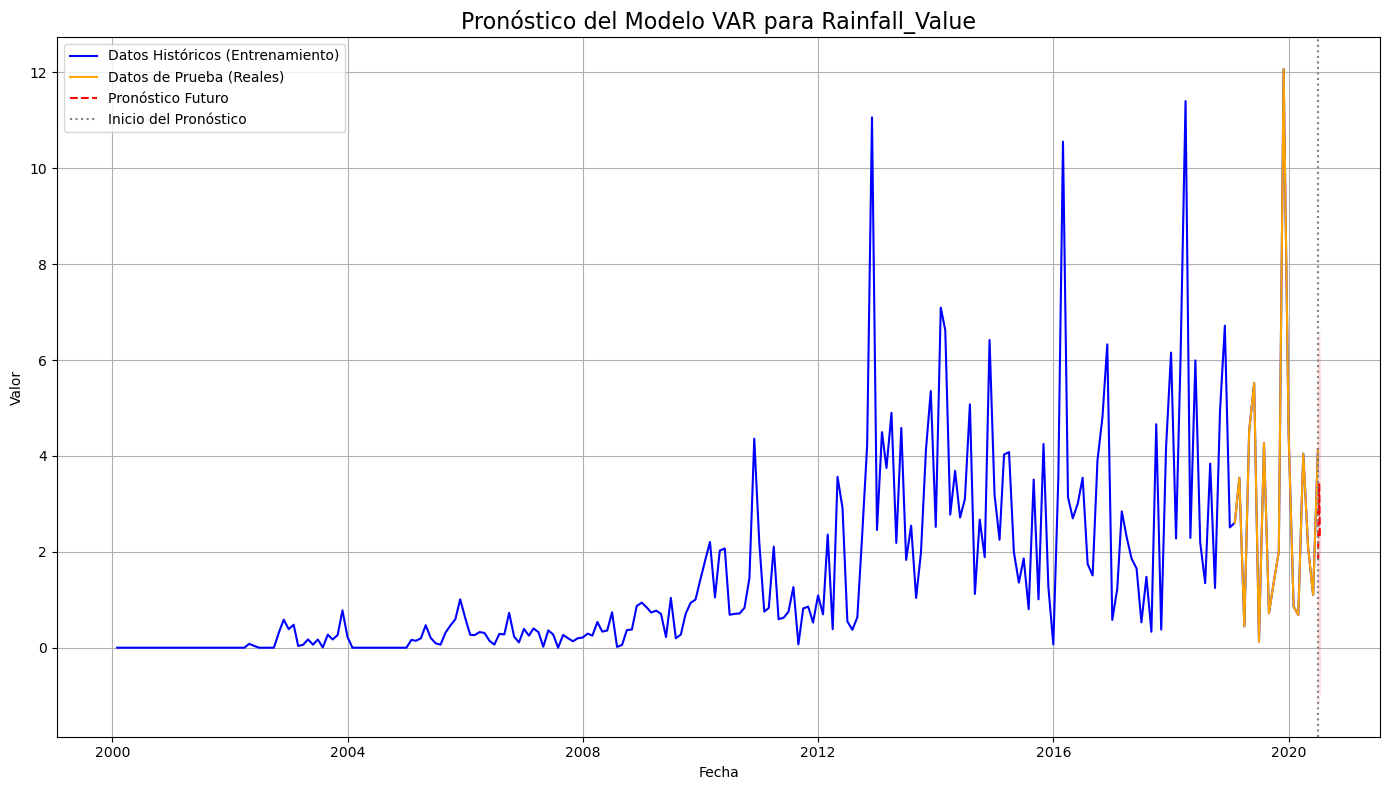

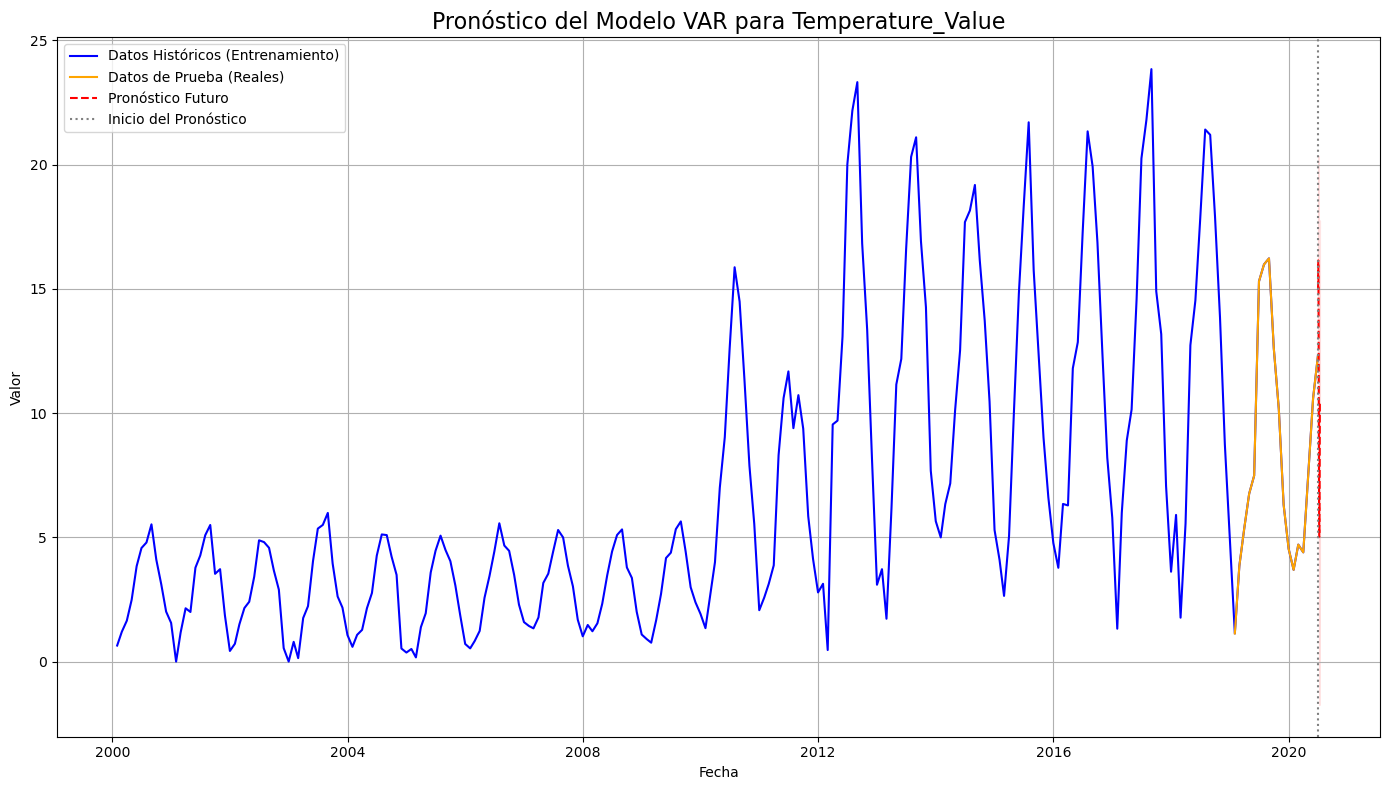

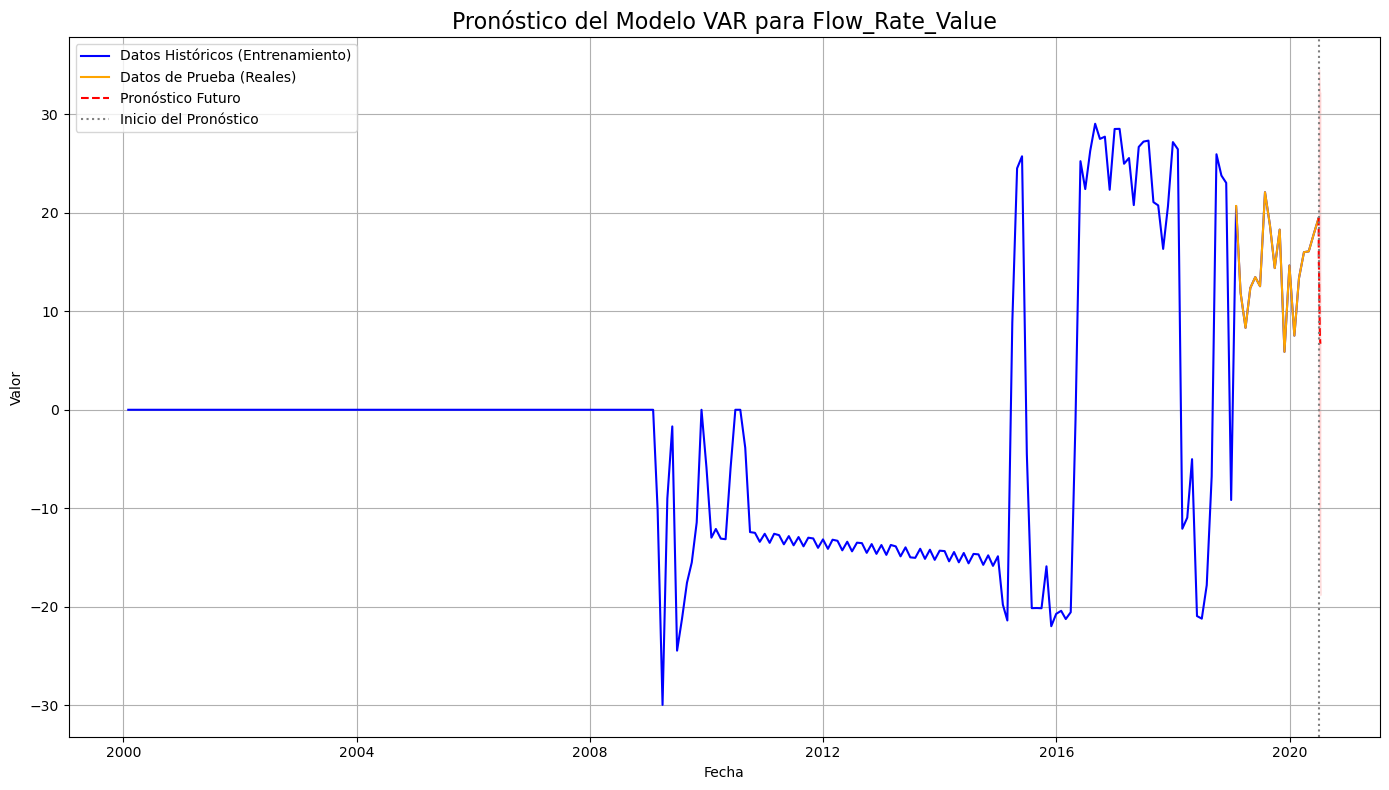

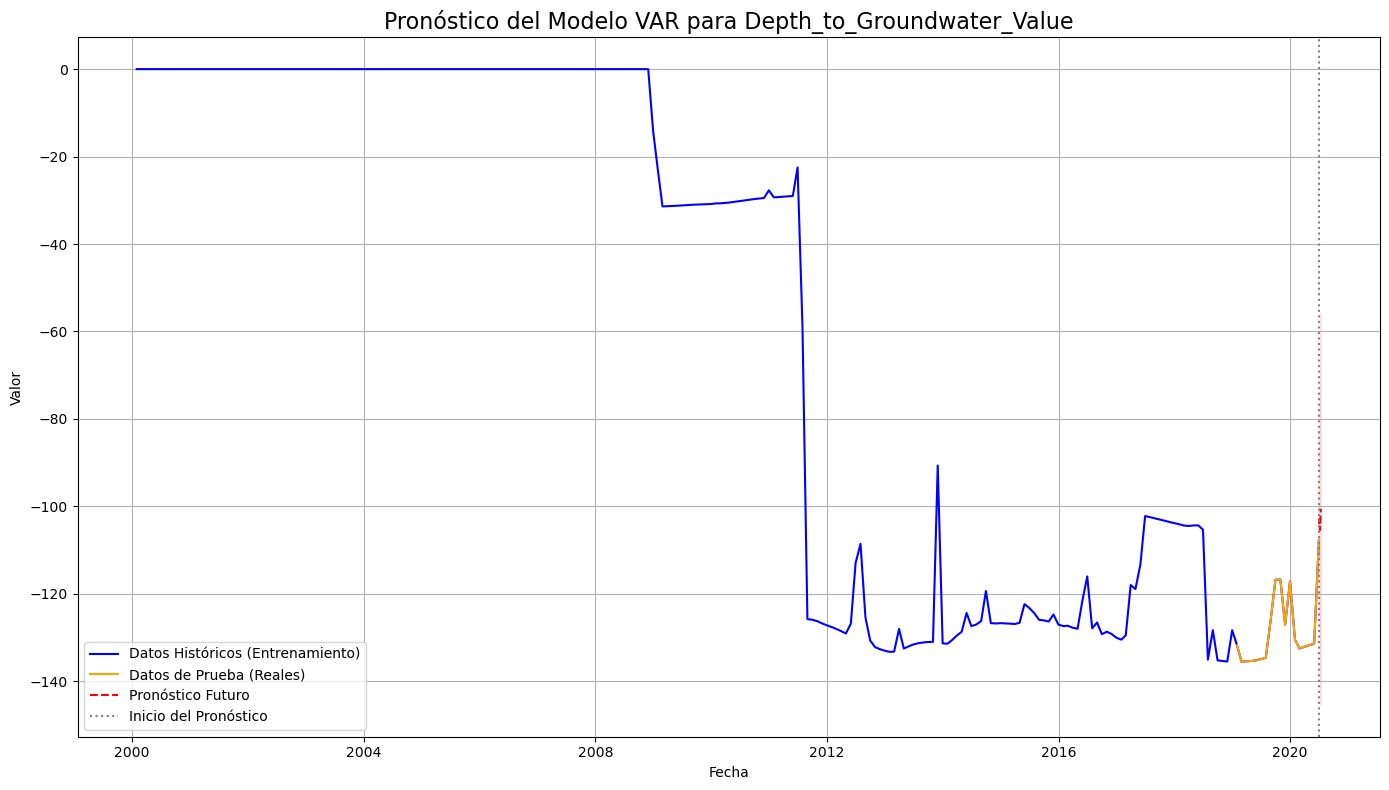

In [11]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# from statsmodels.tsa.api import VAR
# import numpy as np

# Suponiendo que df ya está cargado y preprocesado
# y que var_columns_all está definido
var_columns_all = ['Rainfall_Value', 'Temperature_Value', 'Flow_Rate_Value', 'Depth_to_Groundwater_Value']
df_plot = df[var_columns_all]

# 1. Definir el conjunto de entrenamiento (usando todos los datos disponibles)
train_df = df_plot.copy()
# Número de pasos que quieres predecir en el futuro
n_forecast = 12 

# 2. Entrenar el modelo VAR
model = VAR(train_df)
results = model.fit(maxlags=5, ic='aic')
lag_order = results.k_ar

# 3. Realizar el pronóstico (forecast) y calcular el intervalo de confianza
input_data = train_df.values[-lag_order:]
forecast_result = results.forecast_interval(y=input_data, steps=n_forecast, alpha=0.05)

# 4. Desempaquetar los resultados del pronóstico
# forecast_result devuelve una tupla con (pronóstico, límite inferior, límite superior)
forecast_values = forecast_result[0]
lower_bound = forecast_result[1]
upper_bound = forecast_result[2]

# 5. Crear DataFrames para la predicción futura y sus límites
last_date = train_df.index[-1]
future_dates = pd.date_range(start=last_date, periods=n_forecast + 1, freq=train_df.index.freq)[1:]

forecast_df = pd.DataFrame(forecast_values, index=future_dates, columns=var_columns_all)
lower_df = pd.DataFrame(lower_bound, index=future_dates, columns=var_columns_all)
upper_df = pd.DataFrame(upper_bound, index=future_dates, columns=var_columns_all)

# 6. Visualizar los resultados con el área sombreada
for column in var_columns_all:
    plt.figure(figsize=(14, 8))
    
    # Graficar los datos históricos de entrenamiento
    sns.lineplot(data=train_df[column], label='Datos Históricos (Entrenamiento)', color='blue')

    # Graficar los datos reales del conjunto de prueba
    sns.lineplot(data=test_df[column], label='Datos de Prueba (Reales)', color='orange')
    
    # Graficar el pronóstico futuro
    sns.lineplot(data=forecast_df[column], label='Pronóstico Futuro', color='red', linestyle='--')
    
    # Sombrear el área del intervalo de confianza
    plt.fill_between(forecast_df.index, lower_df[column], upper_df[column], color='red', alpha=0.1)

    plt.axvline(x=forecast_df.index[0], color='gray', linestyle=':', label='Inicio del Pronóstico')
    
    plt.title(f'Pronóstico del Modelo VAR para {column}', fontsize=16)
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 6. Guardar Modelo

In [12]:
# --- Guardar el modelo ---
filename = '../models/water_spring/lakes_prediction_model.pkl'

# Guarda el modelo en el archivo
joblib.dump(results, filename)

print(f"El modelo ha sido guardado en el archivo: {filename}")

El modelo ha sido guardado en el archivo: ../models/water_spring/lakes_prediction_model.pkl
